In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.integrate import simpson


from scipy import stats

from multiprocessing import Pool, cpu_count
from conf_interval import conf_interval_calc



%load_ext autoreload
%autoreload 2

from pairedtest import pairedtest
# regex for number extraction from string
number_pattern =  r'(-?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+-]?\d+)?)'

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':200})

453
451
0.3643
0.3662
0.372
0.3642
0.3708
----------------------------------------
0.359
0.3606
0.367
0.3703
0.367


In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
# res_df_list = [
#     pd.read_csv('./yeast_network_v_model.csv', index_col=0),
#     pd.read_csv('./bsubtilis_network_v_model.csv', index_col=0),
#     pd.read_csv('./arabidopsis_network_v_model.csv', index_col=0),
#     pd.read_csv('./mouse_bulk_network_v_model.csv', index_col=0)
# ]

tf_df_list = [
    pd.read_csv('../output/network_model/yeast_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/bsubtilis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/arabidopsis_tf.csv', index_col=0, names=['tf']),
    pd.read_csv('../output/network_model/mouse_tf.csv', index_col=0, names=['tf']),
]

res_df_list = [
    pd.read_csv('../output/network_model/yeast_all_tf_high_var_target_efron_train.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/bsubtilis_all_tf_high_var_target_efron_train.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/arabidopsis_all_tf_high_var_target_efron_train.csv.gz', index_col=0, compression='gzip'),
    pd.read_csv('../output/network_model/mouse_all_tf_high_var_target_efron_train.csv.gz', index_col=0, compression='gzip'),
]

species_names = ['Yeast', 'B.subtilis', 'Arabidopsis', 'Mouse']
species_file_names = ['yeast', 'bsubtilis', 'arabidopsis', 'mouse']

filtered_df_list = [res_df[res_df['test_std'] > .5] for res_df in res_df_list]

compare_list = ['rf_rmse', 
                'linear_rmse', 
                'gs_rf_rmse', 
                'gs_linear_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                # 'linear_with_top_features_rmse', 
                'rf_efron_rmse']
                # 'linear_dynamic_efron_rmse']

compare_name_list = ['RF with all TFs',
                     'Linear with all TFs',
                     'RF with GS TFs',
                     'Linear with GS TFs',
                     'RF with top TFs',
                    #  'Linear with top TFs (95% top)',
                     'RF with Minimal TF set']
                    #  'Linear with top TFs (Efron)']



In [37]:
res_df_list[1]['gs_edge_num'].mean()

1.8703956343792634

In [39]:
res_df_list[0]['gs_edge_num'].median()

52.0

In [43]:
res_df_list[2]['gs_edge_num'].mean()

12.999284180386542

In [4]:
for df, species_name in zip(res_df_list, species_names):
    print(species_name+': ')
    minimal_set_sizes = []
    small_size_set = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
        if (int(efron_size) < 8):
            small_size_set.append(int(efron_size))
    print(1.0*len(small_size_set)/len(minimal_set_sizes))

Yeast: 
0.9656992084432717
B.subtilis: 
0.7748976807639836
Arabidopsis: 
0.9892627057981389
Mouse: 
0.7258064516129032


In [5]:
for df, species_name in zip(res_df_list, species_names):
    print(species_name+': ')
    print('{}[{}, {}]'.format(df['gs_edge_num'].quantile(.5), df['gs_edge_num'].quantile(.25), df['gs_edge_num'].quantile(.75)))
    print('{}[{}, {}]'.format(df['rf_efron_feature_num'].quantile(.5), df['rf_efron_feature_num'].quantile(.25), df['rf_efron_feature_num'].quantile(.75)))    

Yeast: 
52.0[41.0, 63.5]
3.0[3.0, 3.0]
B.subtilis: 
1.0[1.0, 2.0]
2.0[2.0, 4.0]
Arabidopsis: 
13.0[6.0, 19.0]
3.0[3.0, 3.0]
Mouse: 
4.0[2.0, 7.0]
5.0[2.0, 10.0]


In [6]:
res_df_list[1].columns

Index(['rf_score', 'linear_score', 'gs_rf_score', 'gs_linear_score',
       'rf_with_linear_top_features_score',
       'linear_with_rf_top_features_score', 'rf_rmse', 'linear_rmse',
       'gs_rf_rmse', 'gs_linear_rmse', 'rf_with_linear_top_features_rmse',
       'linear_with_rf_top_features_rmse', 'rf_with_top_features_score',
       'linear_with_top_features_score', 'rf_with_top_features_rmse',
       'linear_with_top_features_rmse', 'rf_top_feature_num',
       'linear_top_feature_num', 'rf_top_features_gs_overlap',
       'linear_top_features_gs_overlap', 'rf_linear_top_features_overlap',
       'gs_edge_num', 'test_var', 'test_std', 'pca_rf_score', 'pca_rf_rmse',
       'rf_efron_feature_num', 'rf_efron_complementary_feature_num_list',
       'rf_efron_rmse', 'rf_efron_complementary_rmse_list',
       'rf_efron_features', 'rf_efron_complementary_features_list',
       'rf_top_tf_same_count_as_gs_score', 'rf_top_tf_same_count_as_gs_rmse',
       'rf_efron_ensemble_rmse', 'rf_efron

In [7]:
for df, species_name in zip(res_df_list, species_names):
    print(species_name)
    res = stats.ttest_rel(df['rf_rmse'], df['rf_efron_ensemble_rmse'])
    print(res)

Yeast
TtestResult(statistic=-5.793587268460595, pvalue=1.452437395991174e-08, df=378)
B.subtilis
TtestResult(statistic=-0.43579323697467, pvalue=0.663115232167588, df=732)
Arabidopsis
TtestResult(statistic=-2.3638365537841812, pvalue=0.018223099777004502, df=1396)
Mouse
TtestResult(statistic=-1.3193270889644917, pvalue=0.18803654171895384, df=309)


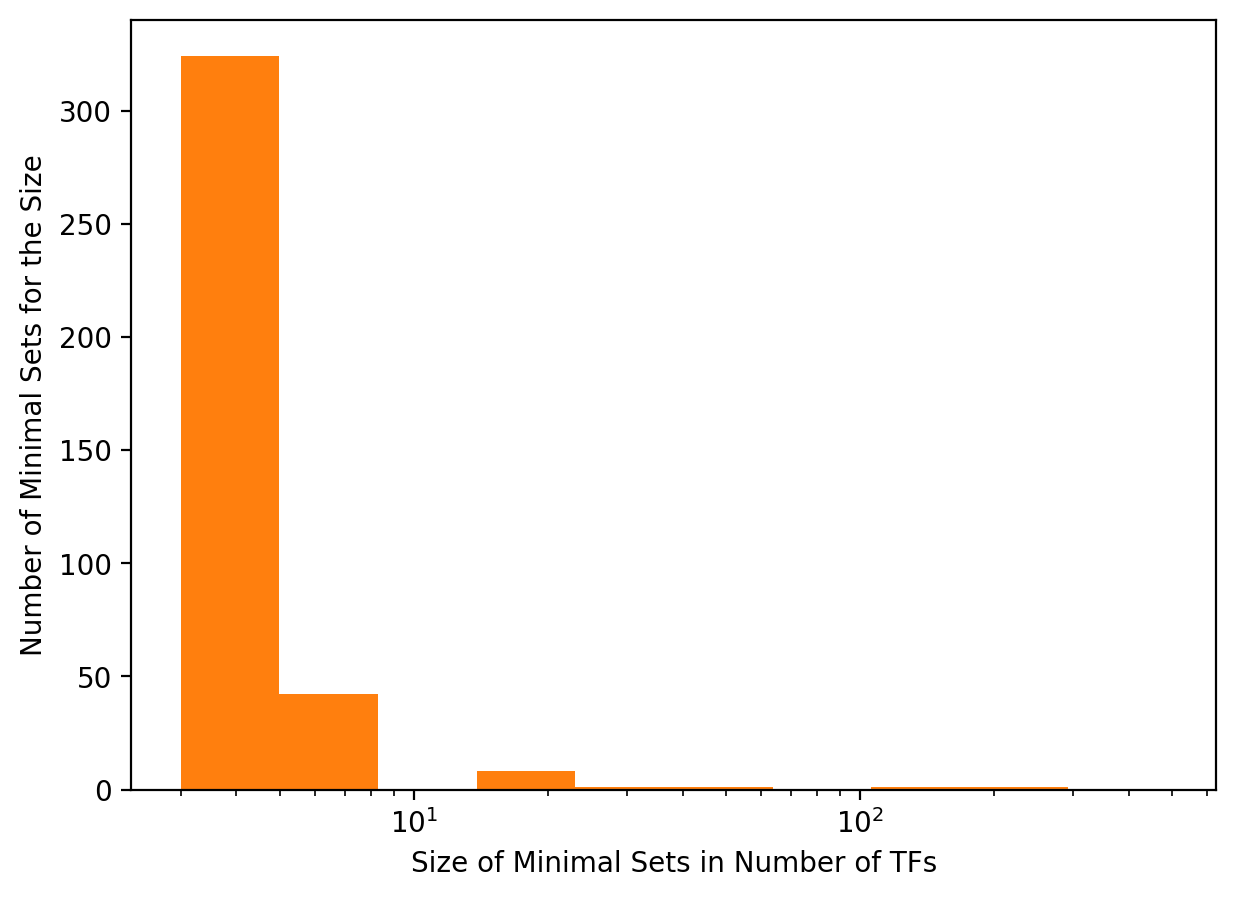

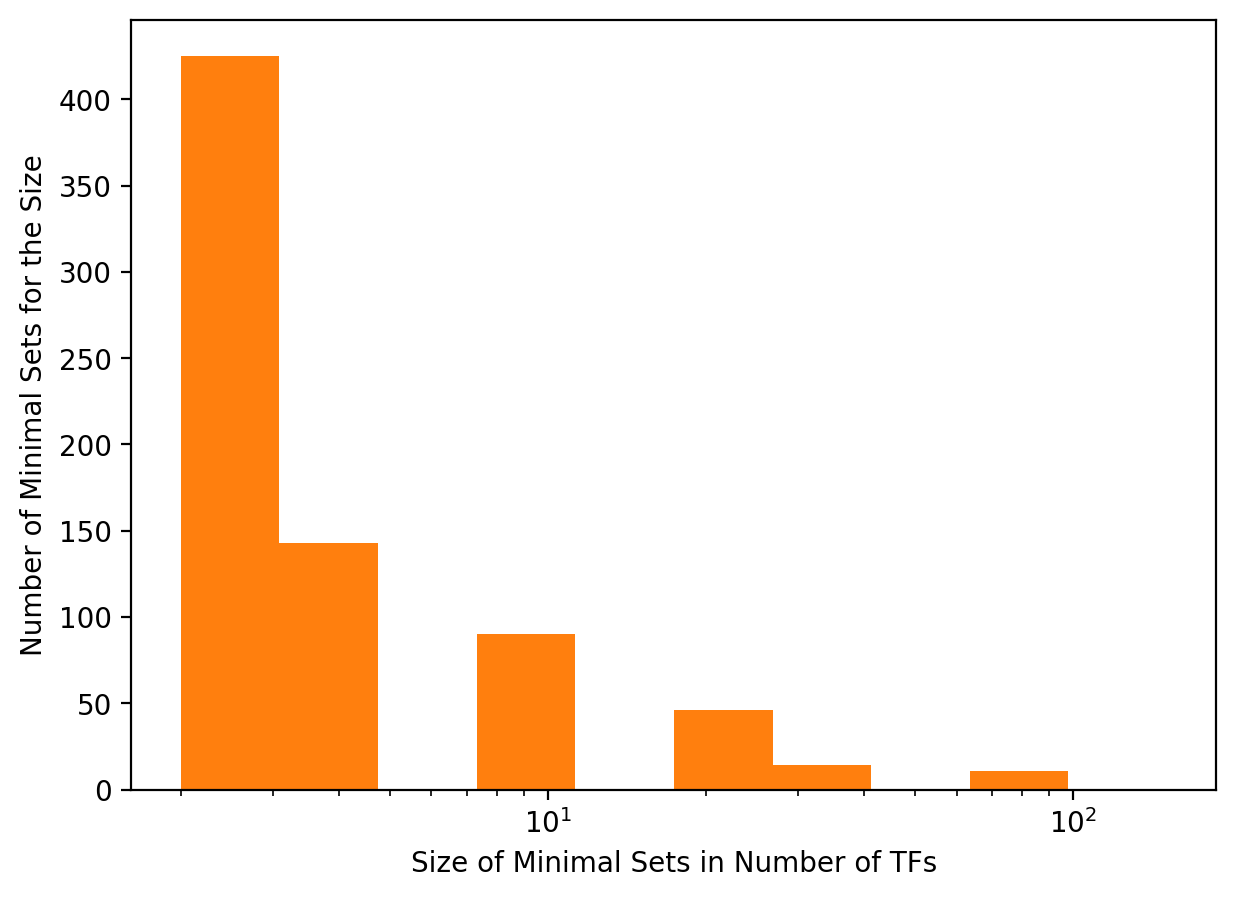

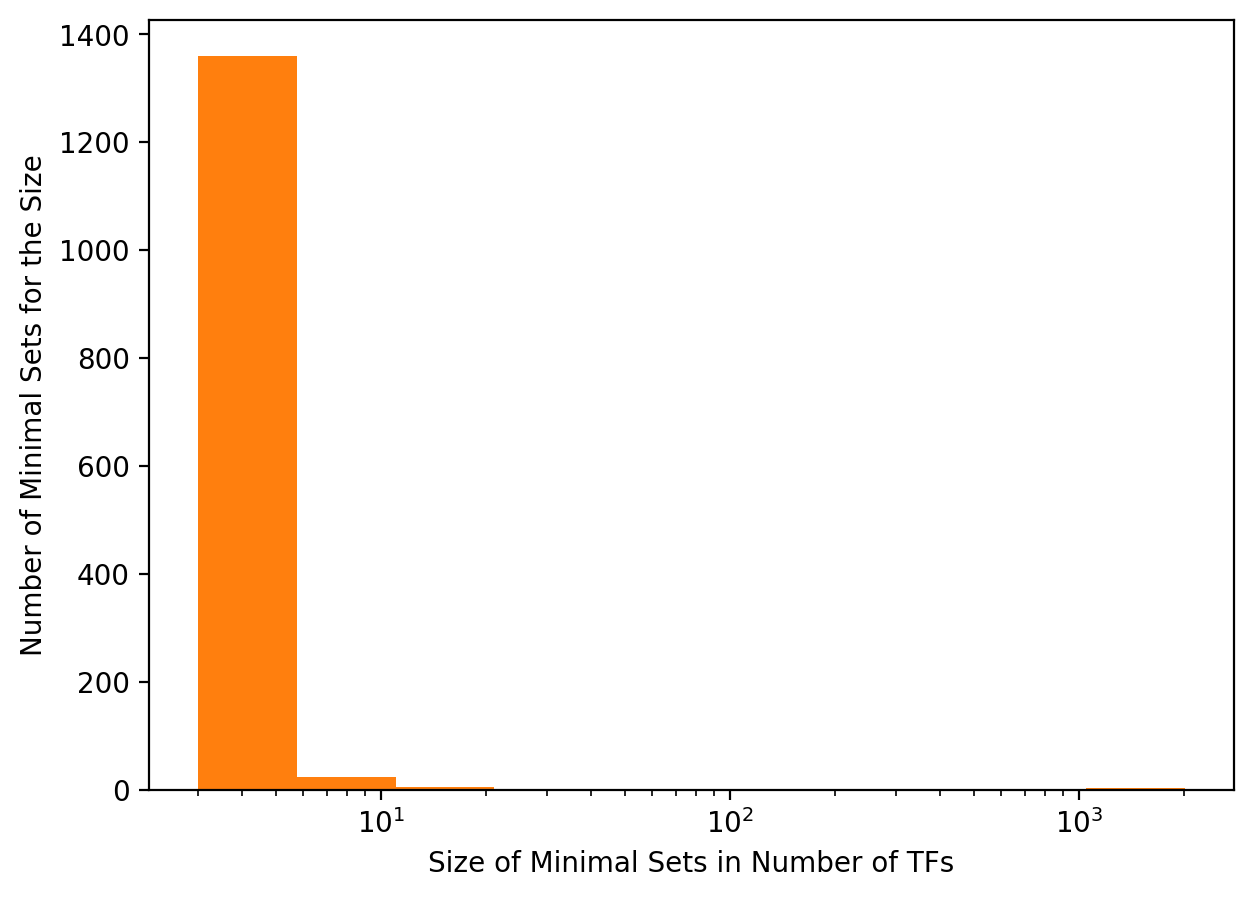

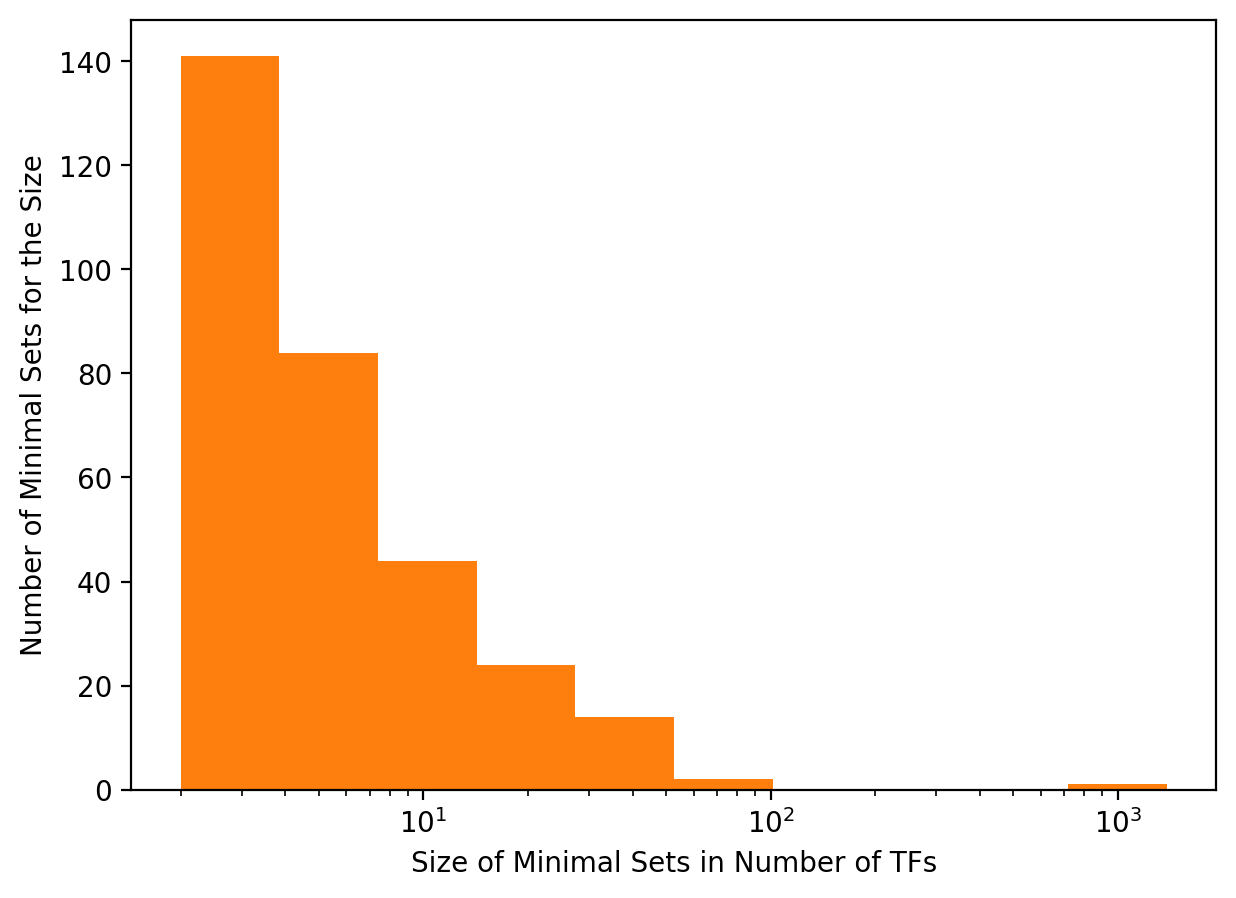

In [8]:

for df, species_name in zip(res_df_list, species_file_names):
    minimal_set_sizes = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        minimal_set_sizes.append(int(efron_size))
    hist, bins = np.histogram(minimal_set_sizes, bins=10)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(minimal_set_sizes, bins=logbins, color=colors[1])
    ax.set_xscale('log')
    ax.set(xlabel='Size of Minimal Sets in Number of TFs')
    ax.set(ylabel='Number of Minimal Sets for the Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    # plt.legend()
    plt.savefig('./plot_output/minimal_sets_size/'+species_name+'.pdf', bbox_inches='tight')

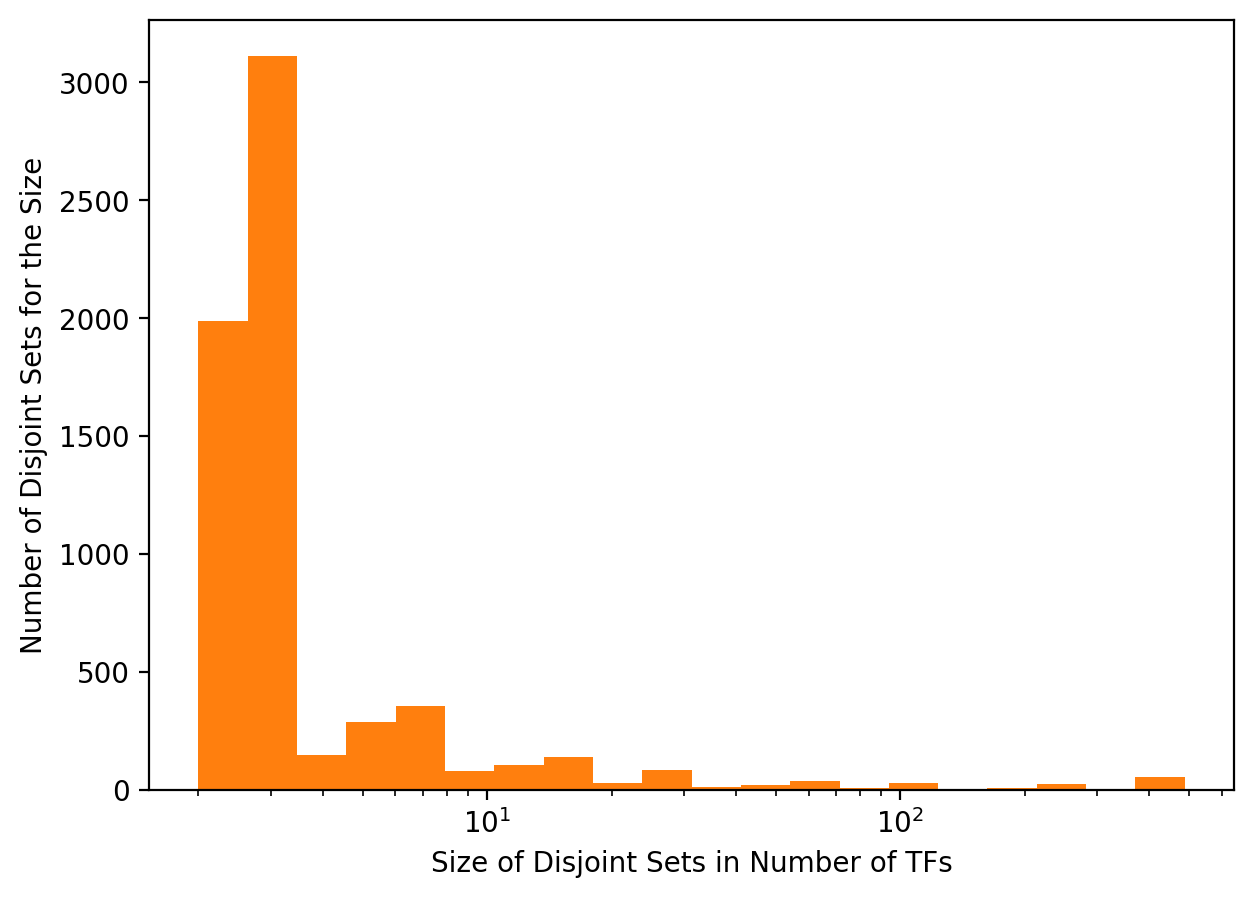

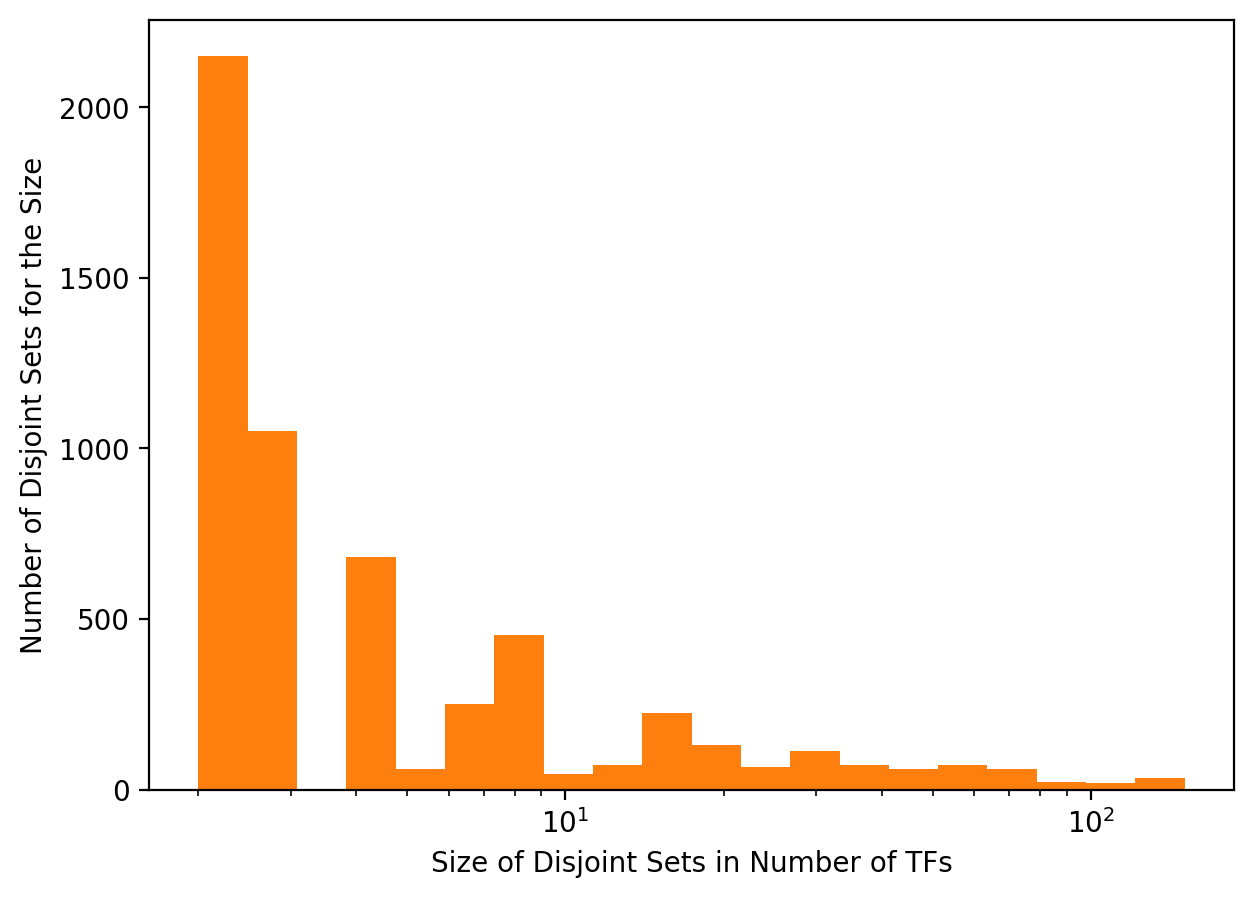

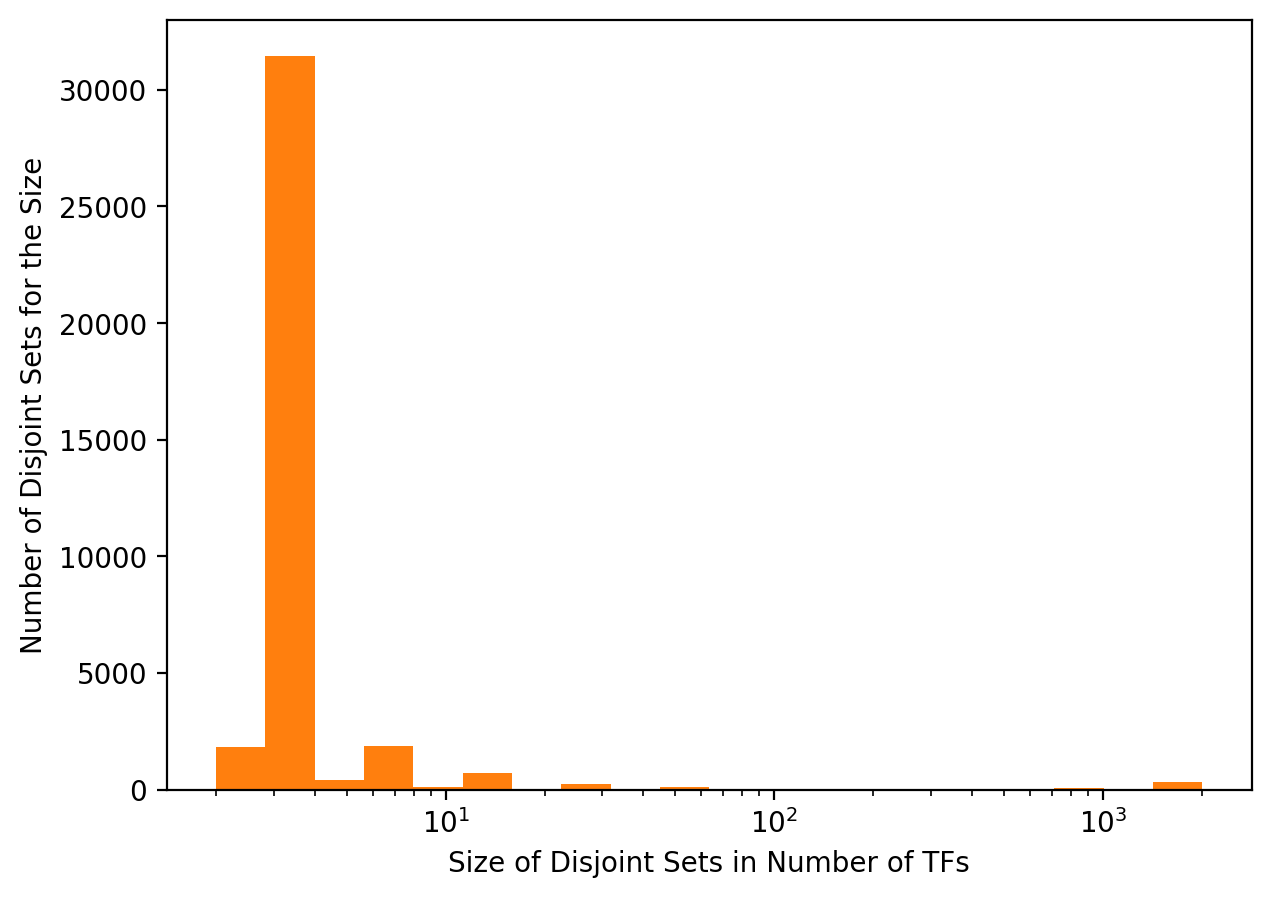

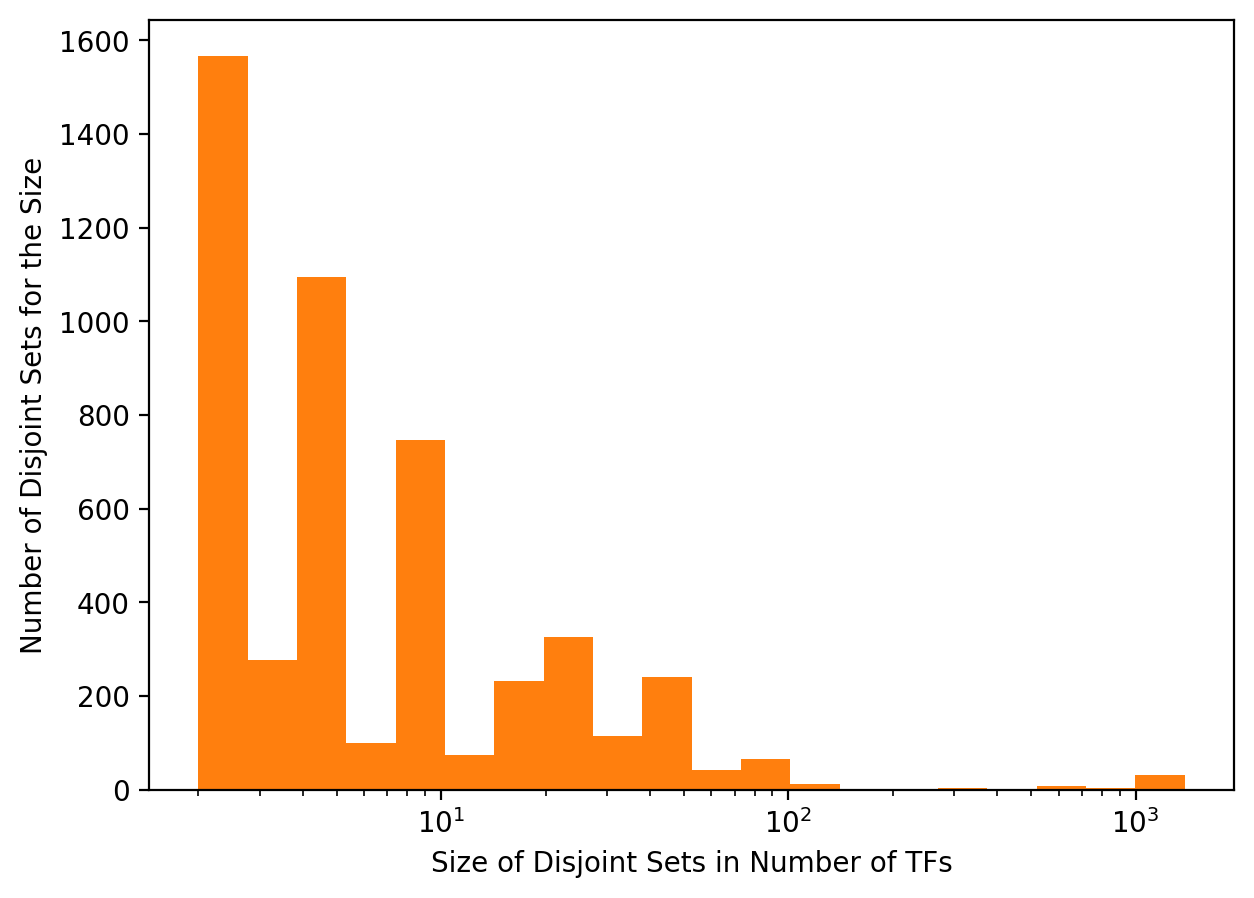

In [9]:

for df, species_name in zip(res_df_list, species_names):
    disjoint_set_sizes = []
    for num_list, efron_size in zip(df['rf_efron_complementary_feature_num_list'], df['rf_efron_feature_num']):
        disjoint_set_sizes.append(int(efron_size))
        if isinstance(num_list, str):
            size_list = [int(i) for i in num_list.split(', ')]
            size_list= list(filter(lambda a: a != 1, size_list))
            disjoint_set_sizes.extend(size_list)
    hist, bins = np.histogram(disjoint_set_sizes, bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(disjoint_set_sizes, bins=logbins, color=colors[1])
    ax.set_xscale('log')
    ax.set(xlabel='Size of Disjoint Sets in Number of TFs')
    ax.set(ylabel='Number of Disjoint Sets for the Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    # plt.legend()
    plt.show()

0.3245382585751979
0.38472032742155526
0.180386542591267
0.2967741935483871


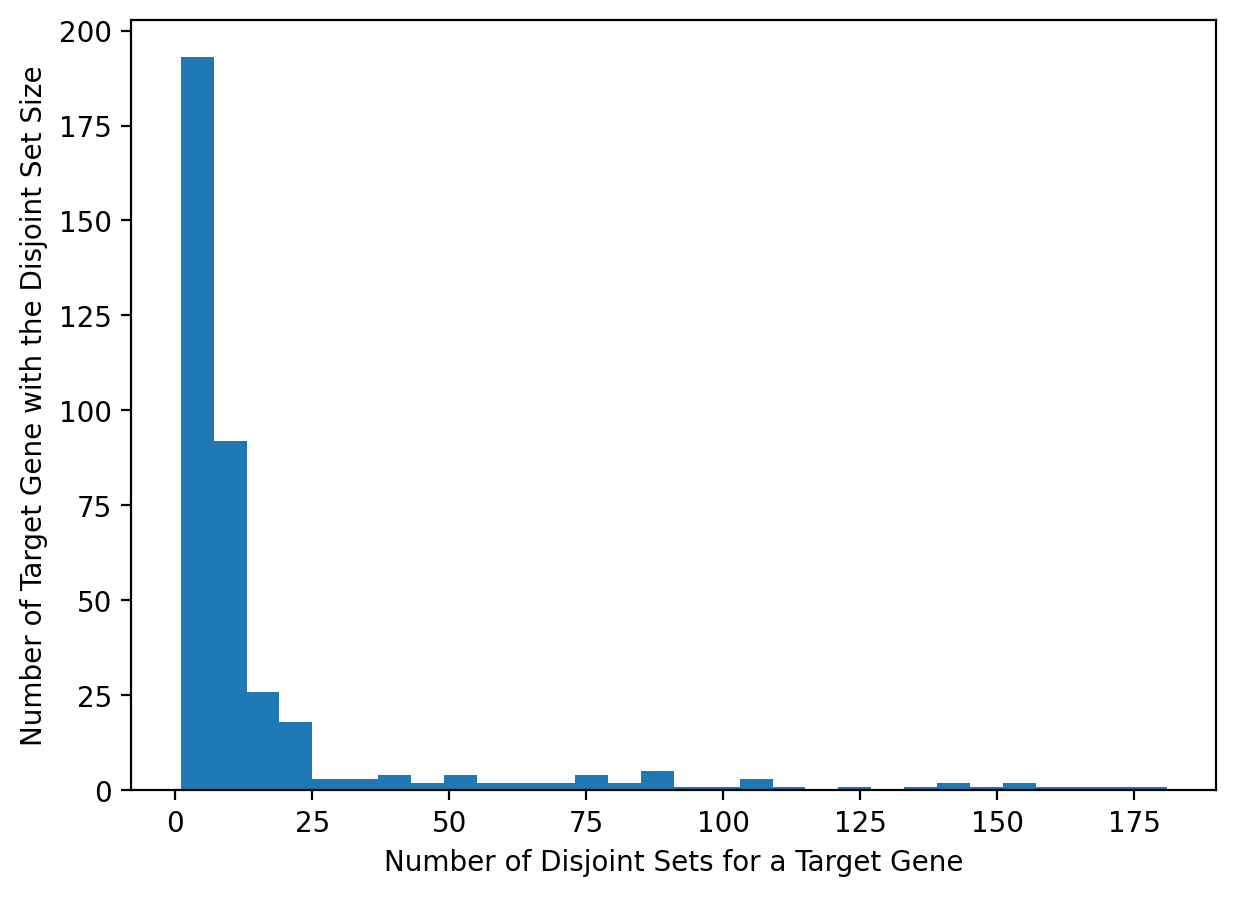

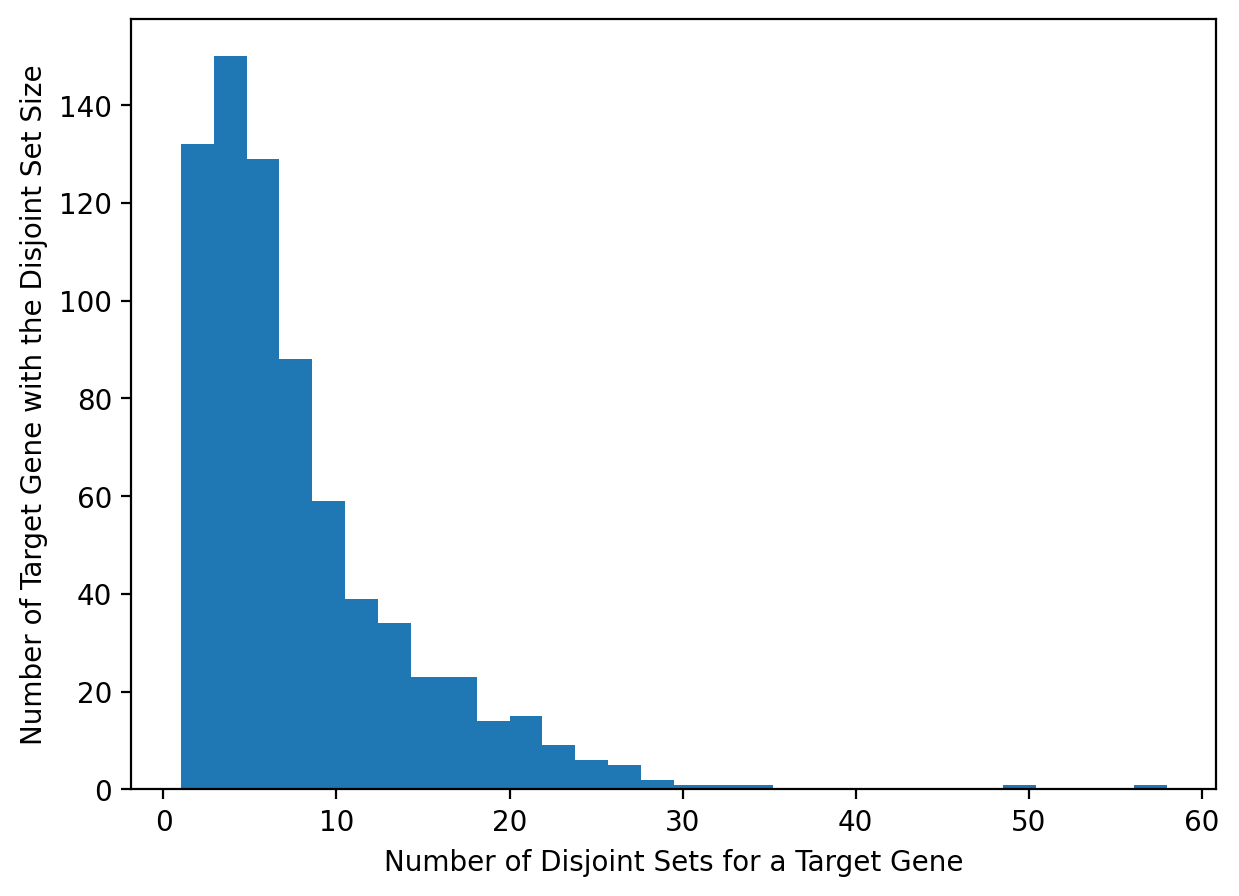

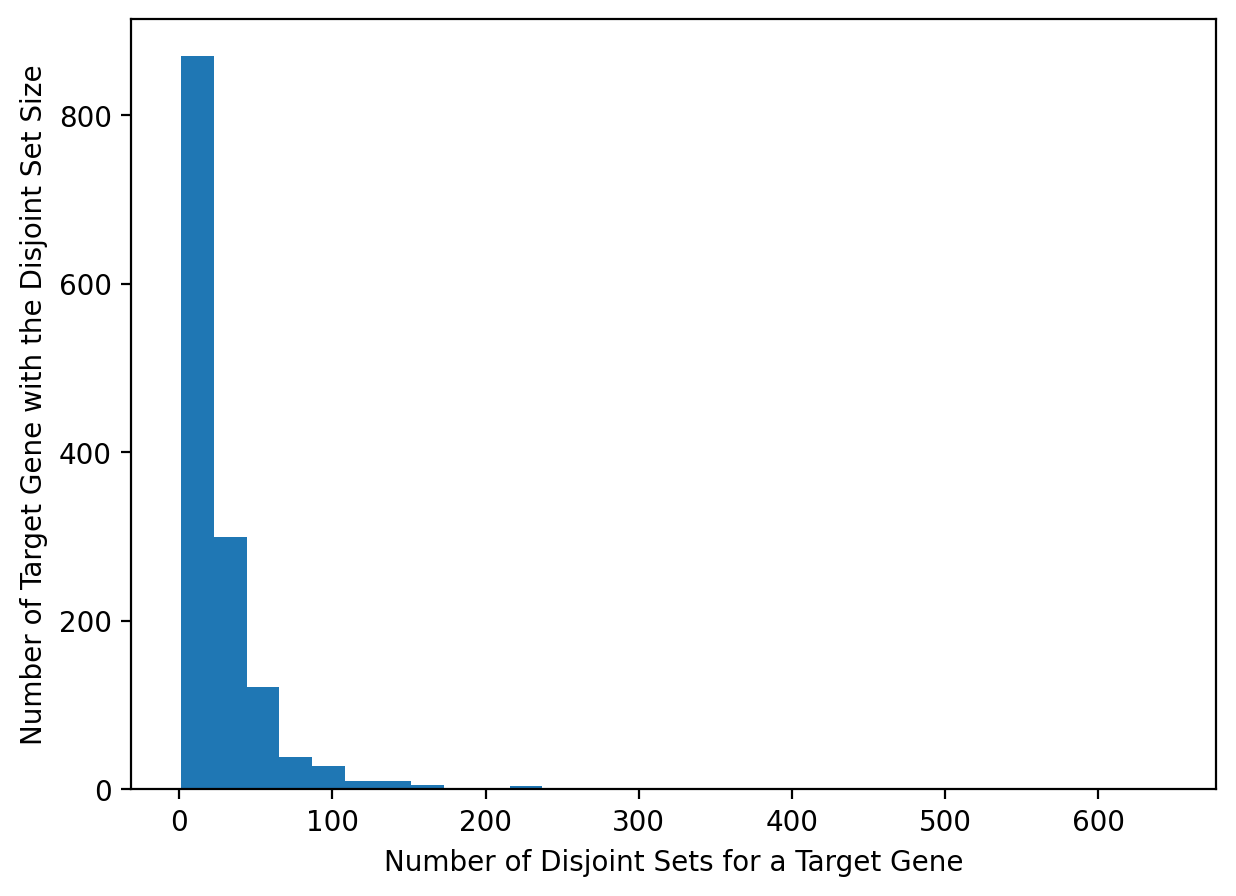

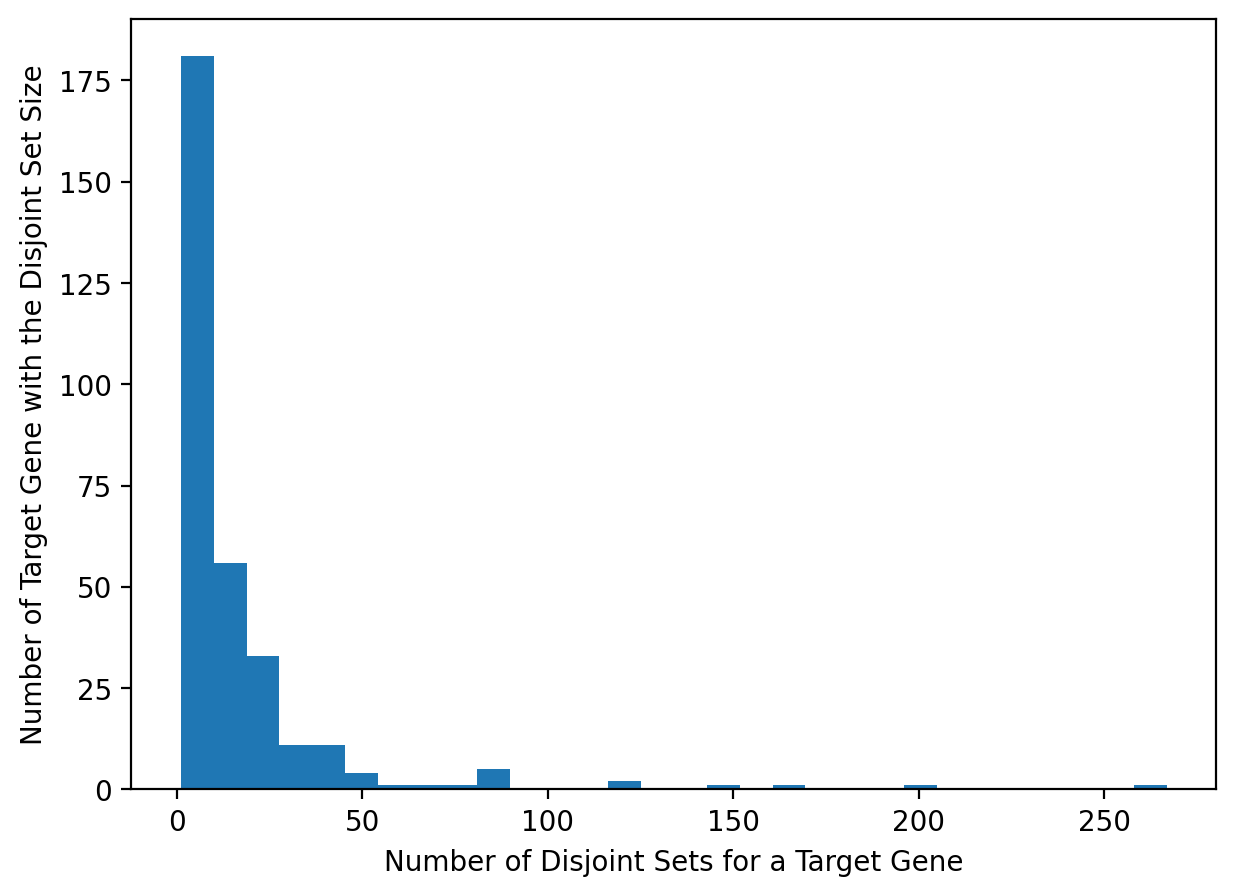

In [10]:
for df, species_name in zip(res_df_list, species_file_names):
    disjoint_set_count = []
    for num_list in df['rf_efron_complementary_feature_num_list']:
        if isinstance(num_list, str):
            disjoint_set_count.append(len(num_list.split(', '))+1)
        else:
            disjoint_set_count.append(1)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(disjoint_set_count, bins=30)
    ax.set(xlabel='Number of Disjoint Sets for a Target Gene')
    ax.set(ylabel='Number of Target Gene with the Disjoint Set Size')
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    print(1.0*sum(i < 5 for i in disjoint_set_count)/len(disjoint_set_count))
    # plt.legend()
    plt.savefig('./plot_output/disjoint_sets_count/'+species_name+'.pdf', bbox_inches='tight')

In [53]:
test_df = res_df_list[3]
df_length = len(test_df)
tf_df = tf_df_list[3]
disjoint_set_dict = {}
for i in range(df_length):
    i_sets = []
    i_sets.append(set([int(idx) for idx in test_df.iloc[i]['rf_efron_features'].split('; ')]))
    complementary_sets = test_df.iloc[i]['rf_efron_complementary_features_list']
    if isinstance(complementary_sets, str):
        complementary_sets = complementary_sets.split(', ')
        complementary_sets = [set([int(idx) for idx in s.split('; ')]) for s in complementary_sets]
        i_sets.extend(complementary_sets)
    
    disjoint_set_dict[i] = []
    for s in i_sets:
        if len(s) < 5:
            disjoint_set_dict[i].append(s)

In [ ]:
def find():
    for i in tqdm(range(df_length)):
        if (len(disjoint_set_dict[i]) < 3):
            continue
        for j in range(i+1, df_length):
            if (len(disjoint_set_dict[j]) < 3):
                continue
            for set_m in disjoint_set_dict[i]:
                for set_n in disjoint_set_dict[j]:
                    if (set_m == set_n) and (len(set_m) > 1):
                        print('common_set:')
                        print(tf_df.index[list(set_n)])
                        print(test_df.index[i])
                        for s in disjoint_set_dict[i]:
                            print(tf_df.index[list(s)])
                        print(test_df.index[j])
                        for s in disjoint_set_dict[j]:
                            print(tf_df.index[list(s)])
                        # return 0

find()

In [5]:
compare_list = ['rf_rmse', 
                'linear_rmse', 
                'gs_rf_rmse', 
                'gs_linear_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                # 'linear_with_top_features_rmse', 
                'rf_efron_rmse']
                # 'linear_dynamic_efron_rmse']

compare_name_list = ['RF with all TFs',
                     'Linear with all TFs',
                     'RF with GS TFs',
                     'Linear with GS TFs',
                     'RF with top TFs',
                    #  'Linear with top TFs (95% top)',
                     'RF with Minimal TF set']
                    #  'Linear with top TFs (Efron)']

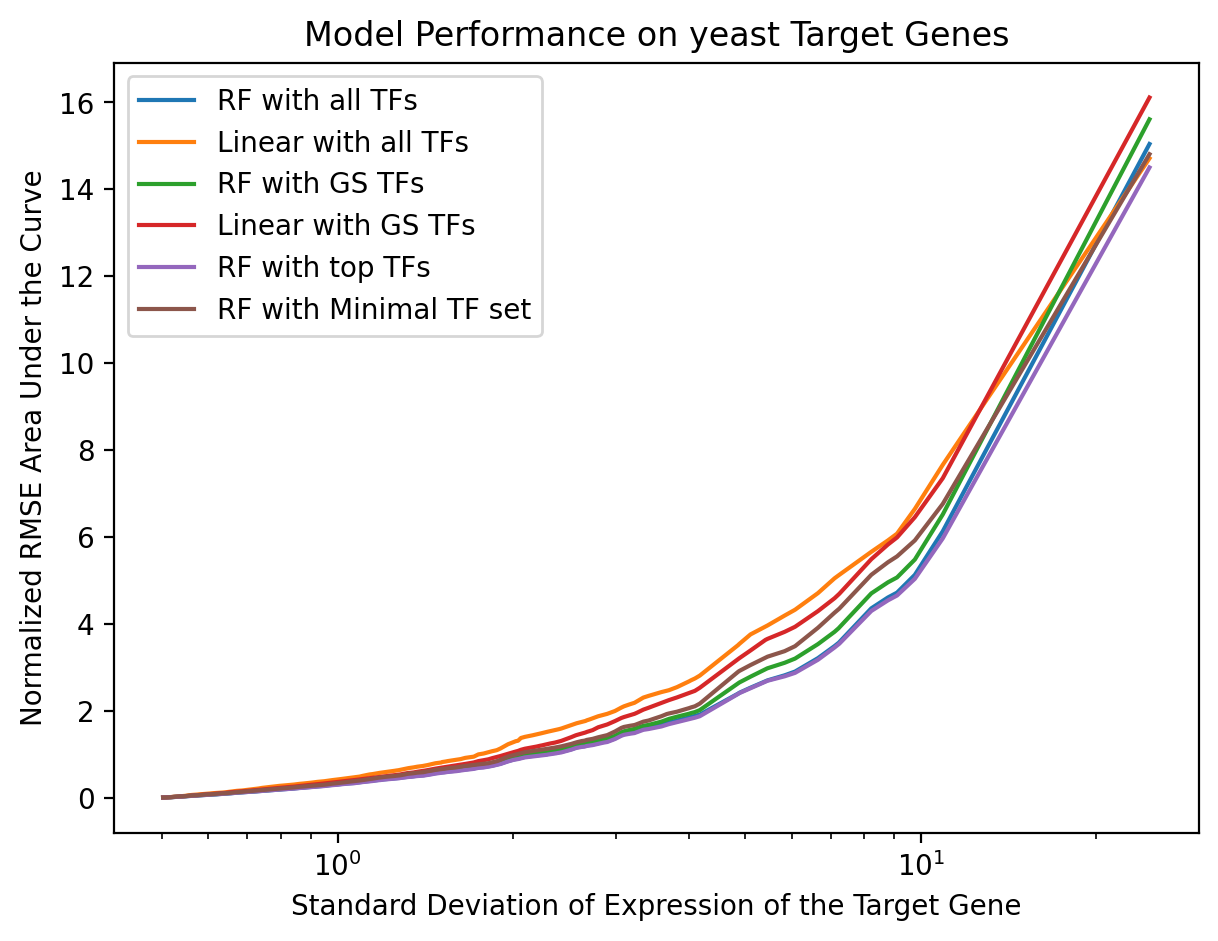

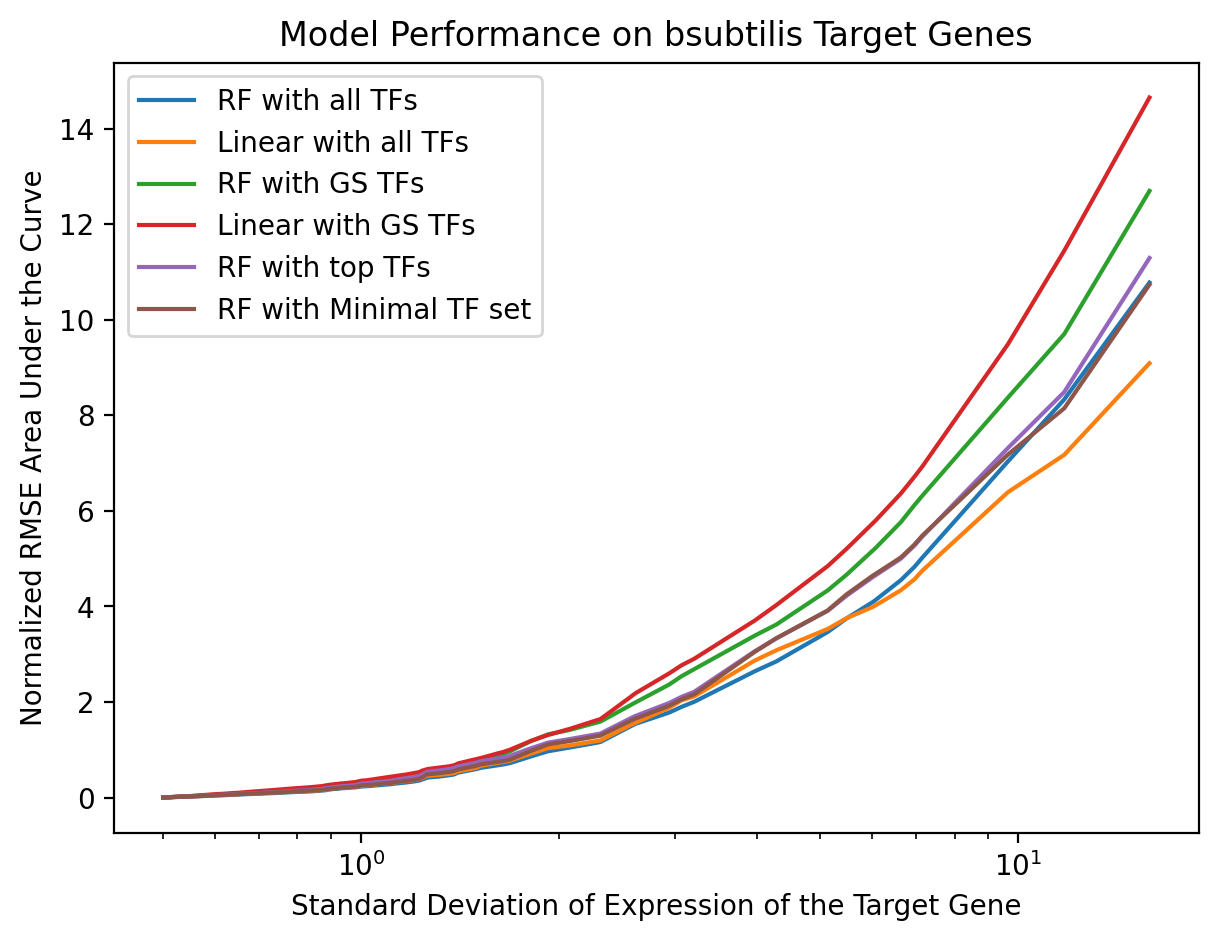

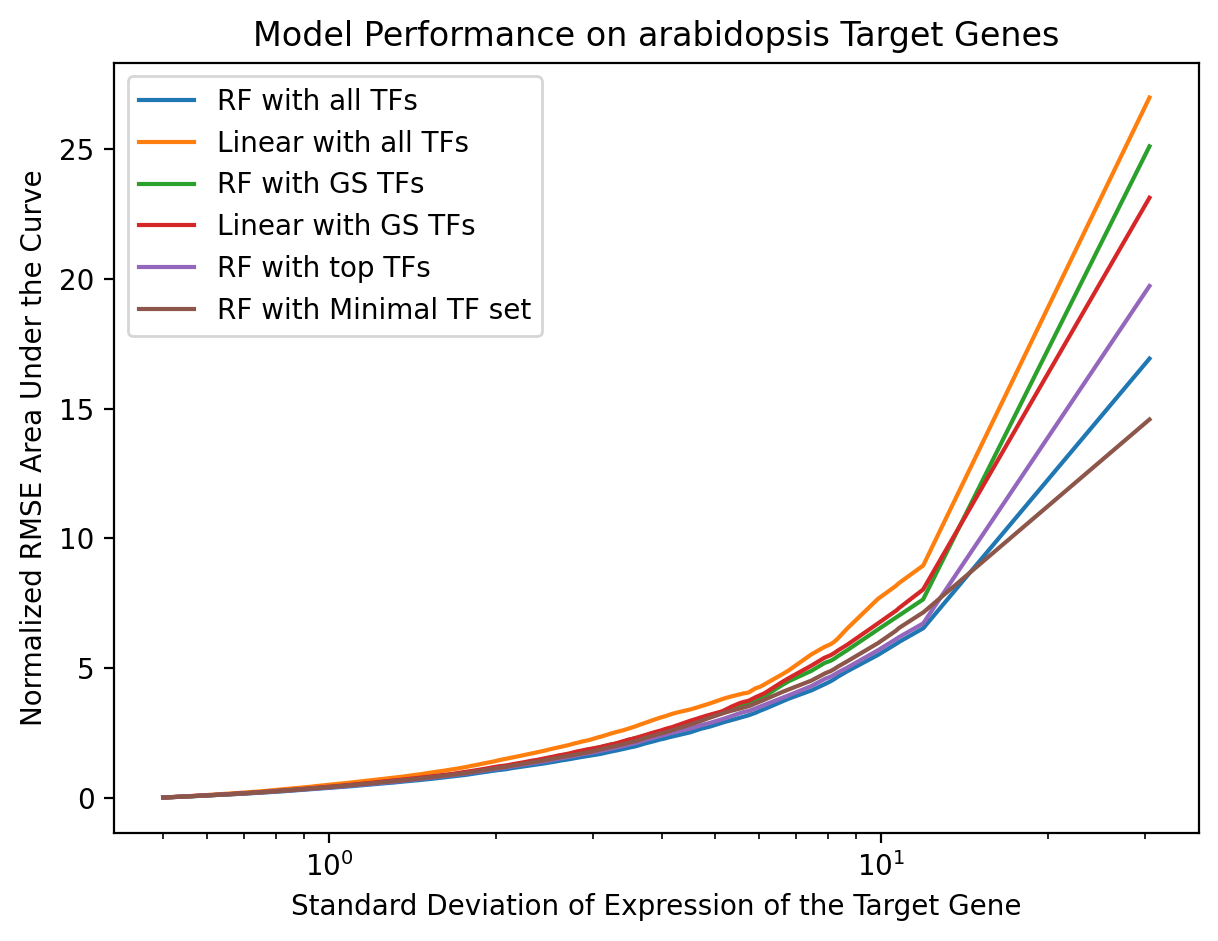

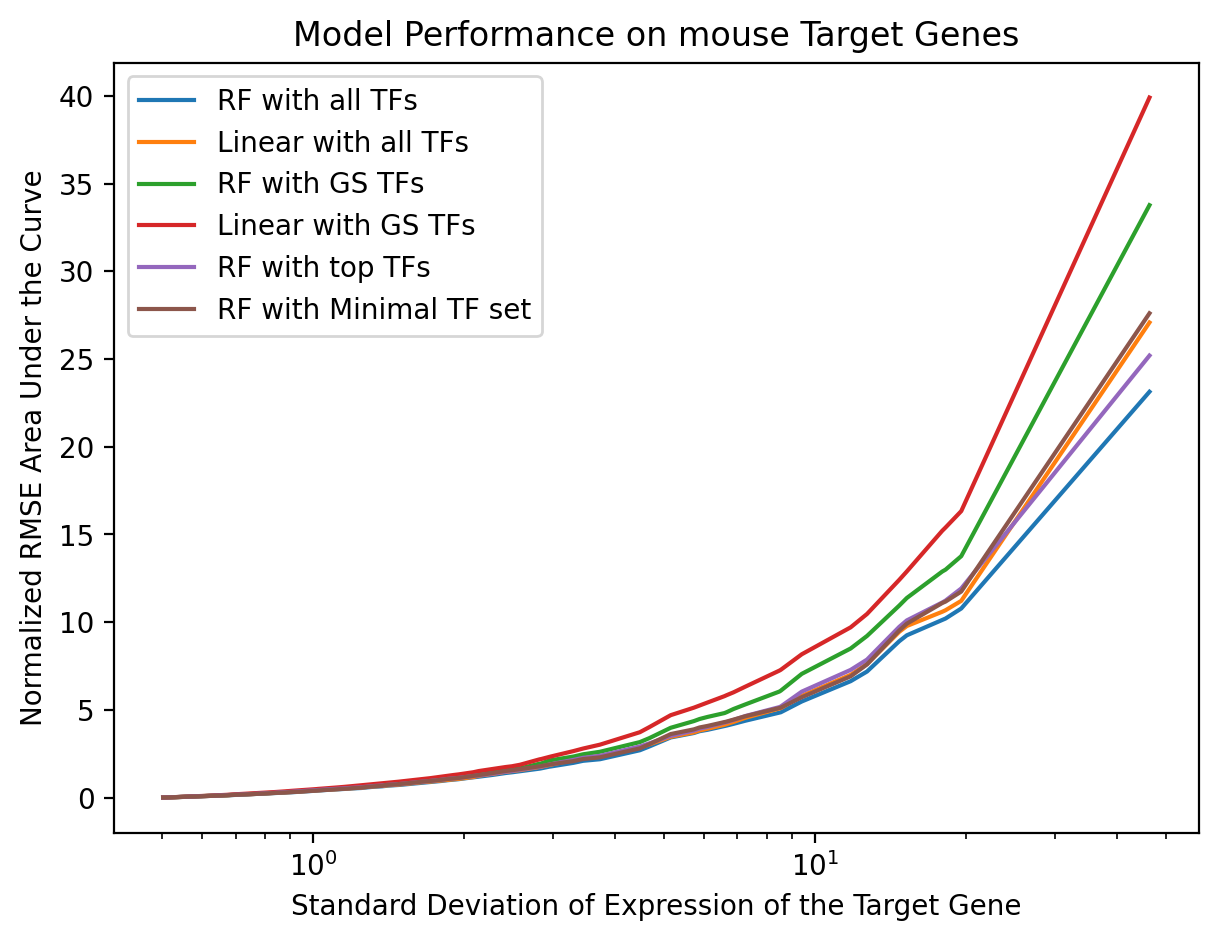

In [6]:
for df, species_name in zip(res_df_list, species_file_names):

    df = df.sort_values('test_std')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    x = df['test_std']

    for model, model_name in zip(compare_list, compare_name_list):
        y = df[model]
        y_norm = y/x
        auc = [np.trapz(y_norm[:i+1], x[:i+1]) for i in range(len(x))]
        ax.plot(x, auc, label=model_name)
    ax.set(xlabel='Standard Deviation of Expression of the Target Gene')
    ax.set(ylabel='Normalized RMSE Area Under the Curve')
    plt.title('Model Performance on '+ species_name +' Target Genes')
    plt.legend()
    plt.show()

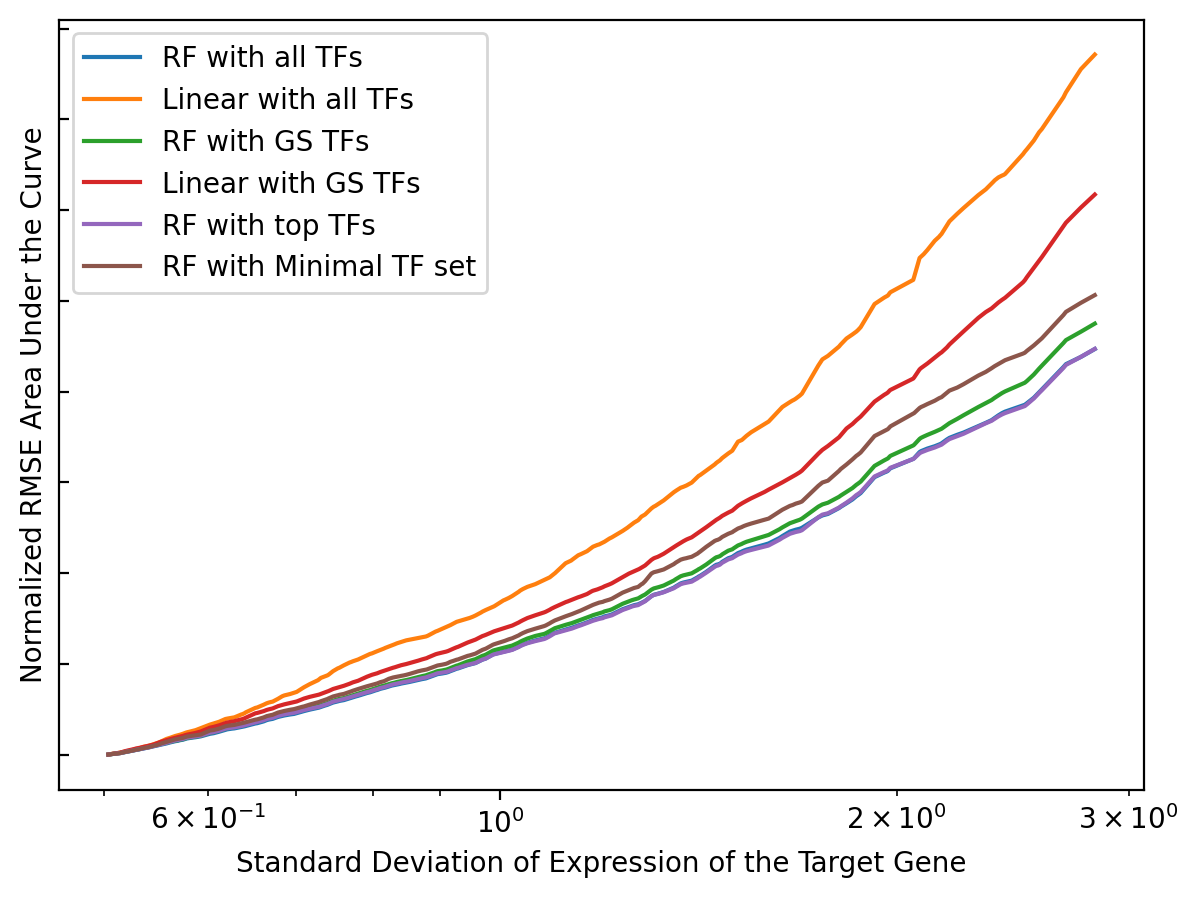

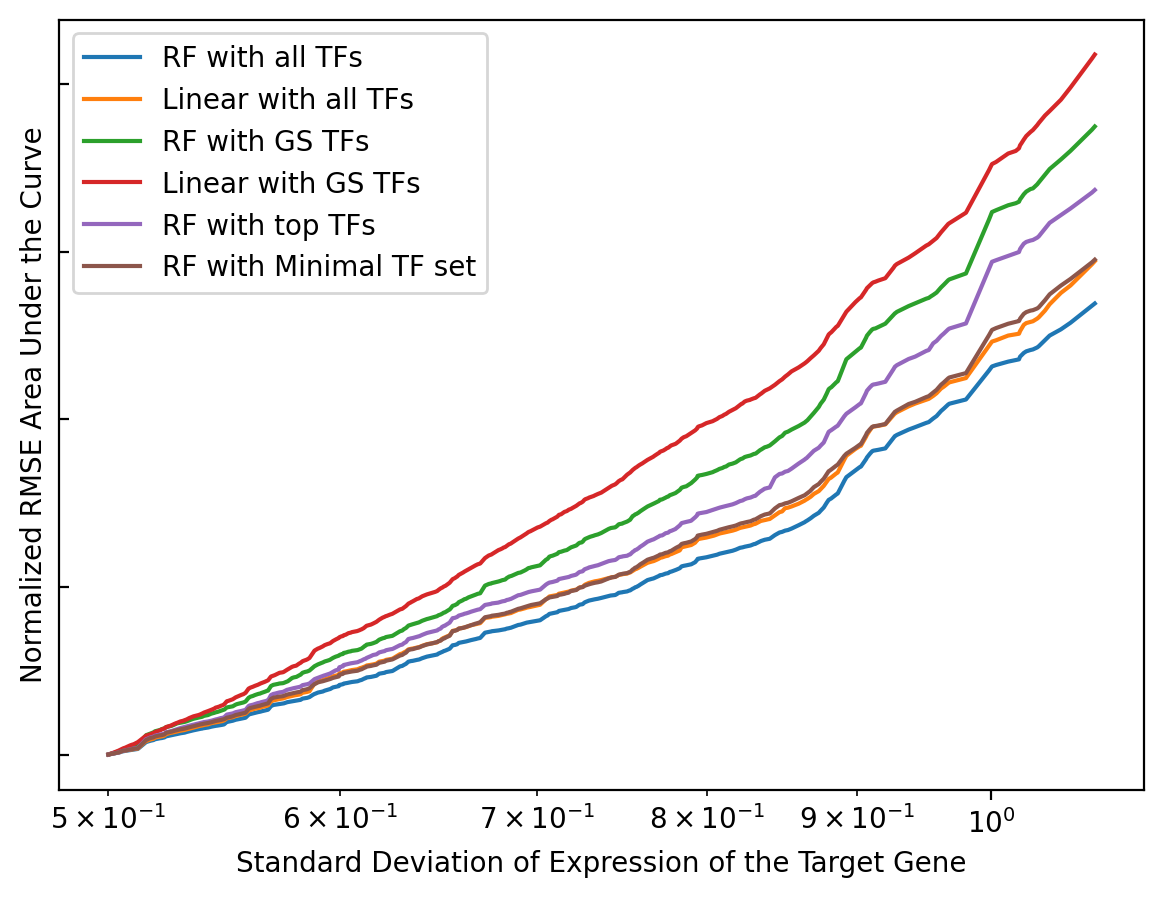

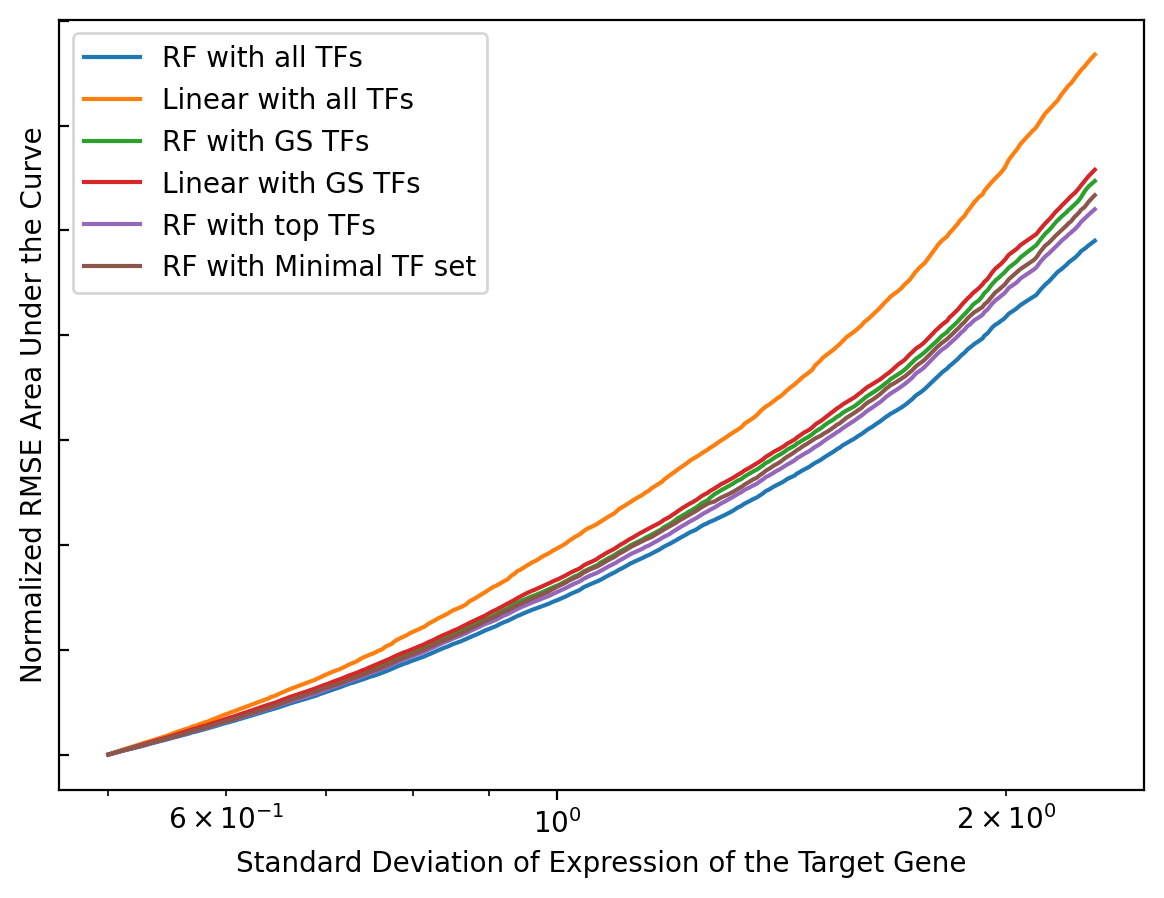

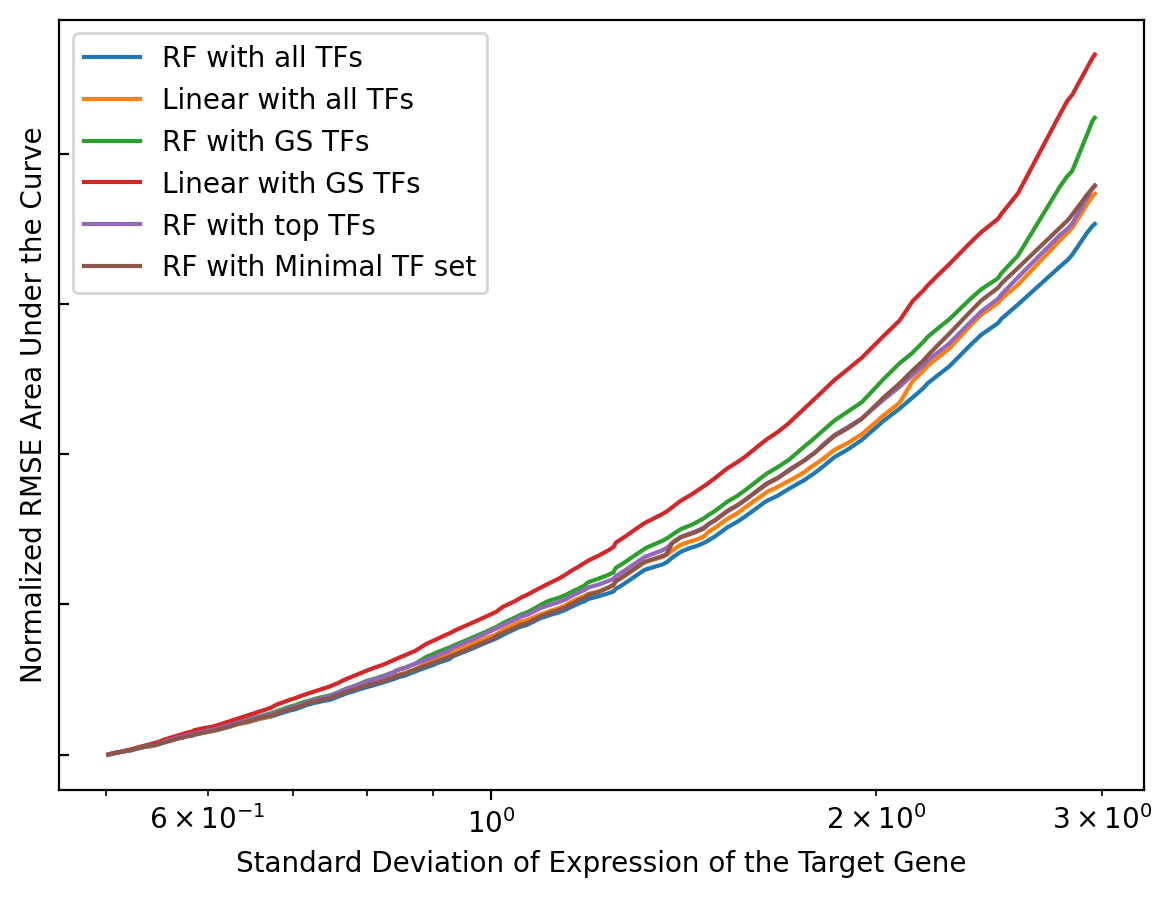

In [25]:
for df, species_name in zip(res_df_list, species_file_names):

    df = df.sort_values('test_std')
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    df = df.sort_values('test_std').head(int(len(df)*(0.9)))
    x = df['test_std']

    for model, model_name in zip(compare_list, compare_name_list):
        y = df[model]
        y_norm = y/x
        auc = [np.trapz(y_norm[:i+1], x[:i+1]) for i in range(len(x))]
        ax.plot(x, auc, label=model_name)
    ax.set(xlabel='Standard Deviation of Expression of the Target Gene')
    ax.set(ylabel='Normalized RMSE Area Under the Curve')
    ax.tick_params(axis="y",direction="in", pad=-22, labelleft=False)
    # ax.tick_params(axis="x",direction="in", pad=-15)
    # plt.title('Model Performance on '+ species_name +' Target Genes')
    plt.legend(loc="best")
    # plt.show()
    plt.savefig('./plot_output/rmse_auc/'+species_name+'.pdf', bbox_inches='tight')

In [ ]:
a = 'linear_rmse'
b = 'gs_linear_rmse'
c = 'rf_rmse'
d = 'gs_rf_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = (df[c] - df[d])/df['test_std']
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = (df[a] - df[b])/df['test_std']
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF Model vs. RF Model Using Gold Standard Network')
axs[0, 1].set_title('LR Model vs. LR Model Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/all_v_gs.pdf', format='pdf', dpi=300)

In [ ]:
a = 'rf_rmse'
b = 'linear_rmse'
c = 'gs_rf_rmse'
d = 'gs_linear_rmse'

fig, axs = plt.subplots(4, 2, figsize=(15, 10))

for i in range(4):
    df = filtered_df_list[i]
    diff = df[a] - df[b]
    diff = (df[a] - df[b])/df['test_std']
    axs[i, 0].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 0].axhline(y=0, color='r', linestyle='-')
    axs[i, 0].set_xscale('log')
    
    diff = df[c] - df[d]
    diff = (df[c] - df[d])/df['test_std']
    axs[i, 1].scatter(df['test_var'], diff, s=0.7, color=plt.cm.tab10(i))
    # plt.scatter(range(len(diff)),diff, s=0.2)
    axs[i, 1].axhline(y=0, color='r', linestyle='-')
    axs[i, 1].set_xscale('log')
    
for i in range(4):
    axs[i, 0].set(ylabel='Difference in RMSE \n (Former - Latter)')
    axs[i, 1].set_ylabel(species_names[i], color=plt.cm.tab10(i), size='large')
    axs[i, 1].yaxis.set_label_position("right")

axs[3, 0].set(xlabel='Expression Variance of the Target Gene')
axs[3, 1].set(xlabel='Expression Variance of the Target Gene')

axs[0, 0].set_title('RF vs. LR Regression Using all TFs')
axs[0, 1].set_title('RF vs. LR Regression Using Gold Standard Network')
fig.tight_layout()
fig.savefig('./plot_output/rf_v_lr.pdf', format='pdf', dpi=300)

In [9]:
compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}Linear with \\ \color{blue}all TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}Linear with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

df = res_df_list[0]

mean_row_list = ["Mean RMSE"]
for model in compare_list:
    mean_row_list.append(f'{df[model].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(6):
    row_str_list = []
    row_str_list.append(compare_row_list[i])
    for j in range(6):
        if (j == i):
            row_str_list.append("-")
        else:
            t_res = stats.ttest_rel(df[compare_list[i]], df[compare_list[j]])
            non_parametric_res = stats.wilcoxon(df[compare_list[i]], df[compare_list[j]])
            prefix = ""
            if (t_res.statistic < 0) and (non_parametric_res.pvalue < 0.05):
                prefix = r"\color{blue}"
            elif (t_res.statistic > 0) and (non_parametric_res.pvalue < 0.05):
                prefix = r"\color{red}"
            ci_res = t_res.confidence_interval()
            row_str_list.append(prefix + '('+f'{ci_res[0]:.3f}'+', '+f'{ci_res[1]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)
            

Mean RMSE & 0.803 & 1.206 & 0.843 & 1.041 & 0.797 & 0.875 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & - & \color{blue}(-0.479, -0.327) & \color{blue}(-0.052, -0.028) & \color{blue}(-0.287, -0.190) & \color{red}(-0.003, 0.015) & \color{blue}(-0.097, -0.047) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}all TFs} & \color{red}(0.327, 0.479) & - & \color{red}(0.289, 0.438) & \color{red}(0.095, 0.234) & \color{red}(0.333, 0.485) & \color{red}(0.259, 0.403) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & \color{red}(0.028, 0.052) & \color{blue}(-0.438, -0.289) & - & \color{blue}(-0.246, -0.152) & \color{red}(0.033, 0.059) & \color{blue}(-0.057, -0.007) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}GS TFs} & \color{red}(0.190, 0.287) & \color{blue}(-0.234, -0.095) & \color{red}(0.152, 0.246) & - & \color{red}(0.195, 0.294) & \color{red}(0.123, 0.210) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top 

In [16]:
compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}Linear with \\ \color{blue}all TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}Linear with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

df = res_df_list[3]

mean_row_list = ["Mean RMSE"]
for model in compare_list:
    mean_row_list.append(f'{df[model].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(6):
    row_str_list = []
    row_str_list.append(compare_row_list[i])
    for j in range(6):
        if (j == i):
            row_str_list.append("-")
        else:
            t_res = stats.ttest_rel(df[compare_list[i]], df[compare_list[j]])
            non_parametric_res = pairedtest(df[compare_list[i]], df[compare_list[j]], 10000)
            prefix = ""
            if (t_res.statistic < 0) and (non_parametric_res < 0.05):
                prefix = r"\color{blue}"
            elif (t_res.statistic > 0) and (non_parametric_res < 0.05):
                prefix = r"\color{red}"
            ci_res = t_res.confidence_interval()
            row_str_list.append(prefix + '('+f'{ci_res[0]:.3f}'+', '+f'{ci_res[1]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)
            

Mean RMSE & 1.195 & 1.305 & 1.490 & 1.686 & 1.310 & 1.321 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & - & \color{blue}(-0.221, 0.001) & \color{blue}(-0.450, -0.139) & \color{blue}(-0.671, -0.311) & \color{blue}(-0.165, -0.065) & \color{blue}(-0.217, -0.034) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}all TFs} & \color{red}(-0.001, 0.221) & - & \color{blue}(-0.274, -0.096) & \color{blue}(-0.503, -0.259) & (-0.130, 0.120) & (-0.080, 0.049) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & \color{red}(0.139, 0.450) & \color{red}(0.096, 0.274) & - & \color{blue}(-0.279, -0.113) & \color{red}(0.022, 0.338) & \color{red}(0.070, 0.269) & \\ \midrule
\makecell{\color{blue}Linear with \\ \color{blue}GS TFs} & \color{red}(0.311, 0.671) & \color{red}(0.259, 0.503) & \color{red}(0.113, 0.279) & - & \color{red}(0.197, 0.555) & \color{red}(0.236, 0.494) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top TFs} & \color{red}(0.

In [8]:
compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}Linear with \\ \color{blue}all TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}Linear with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

df = res_df_list[0]

mean_row_list = ["Mean RMSE"]
for model in compare_list:
    mean_row_list.append(f'{df[model].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(6):
    row_str_list = []
    row_str_list.append(compare_row_list[i])
    for j in range(6):
        if (j == i):
            row_str_list.append("-")
        else:
            ci_res = conf_interval_calc(df[compare_list[i]] - df[compare_list[j]])
            mean_diff = (df[compare_list[i]] - df[compare_list[j]]).mean()
            non_parametric_res = stats.wilcoxon(df[compare_list[i]], df[compare_list[j]])
            prefix = ""
            if (mean_diff < 0) and (non_parametric_res.pvalue < 0.05):
                prefix = r"\color{blue}"
            elif (mean_diff > 0) and (non_parametric_res.pvalue < 0.05):
                prefix = r"\color{red}"
            row_str_list.append(prefix + '('+f'{ci_res[2]:.3f}'+', '+f'{ci_res[3]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)
            

Mean RMSE & 0.877 & 1.204 & 0.922 & 1.091 & 0.859 & 0.965 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & - & \color{blue}(-0.399, -0.262) & \color{blue}(-0.060, -0.034) & \color{blue}(-0.266, -0.171) & \color{red}(0.008, 0.027) & \color{blue}(-0.122, -0.059) & \\ \midrule


KeyboardInterrupt: 

In [81]:
ensemble_compare_list = ['rf_rmse',  
                'gs_rf_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                'rf_efron_rmse']

ensemble_compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

mean_row_list = ["Mean RMSE"]
for df in res_df_list:
    mean_row_list.append(f'{df["rf_efron_ensemble_rmse"].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(4):
    row_str_list = []
    row_str_list.append(ensemble_compare_row_list[i])
    for df in res_df_list:
        t_res = stats.ttest_rel(df[ensemble_compare_list[i]], df['rf_efron_ensemble_rmse'])
        non_parametric_res = stats.wilcoxon(df[ensemble_compare_list[i]], df['rf_efron_ensemble_rmse'])
        prefix = ""
        if (t_res.statistic < 0) and (non_parametric_res.pvalue < 0.05):
            prefix = r"\color{blue}"
        elif (t_res.statistic > 0) and (non_parametric_res.pvalue < 0.05):
            prefix = r"\color{red}"
        ci_res = t_res.confidence_interval()
        row_str_list.append(prefix + '('+f'{ci_res[0]:.3f}'+', '+f'{ci_res[1]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)


Mean RMSE & 0.843 & 0.457 & 0.857 & 1.222 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & \color{blue}(-0.053, -0.026) & \color{blue}(-0.010, 0.006) & \color{blue}(-0.013, -0.001) & \color{blue}(-0.066, 0.013) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & (-0.015, 0.016) & \color{red}(0.118, 0.165) & \color{red}(0.085, 0.129) & \color{red}(0.143, 0.394) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top TFs} & \color{blue}(-0.059, -0.033) & \color{red}(0.063, 0.102) & \color{red}(0.029, 0.047) & \color{red}(0.024, 0.152) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}minimal TF set} & \color{red}(0.008, 0.057) & \color{red}(0.021, 0.061) & \color{red}(0.052, 0.077) & \color{red}(0.035, 0.163) & \\ \midrule


In [17]:
ensemble_compare_list = ['rf_rmse',  
                'gs_rf_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                'rf_efron_rmse']

ensemble_compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

mean_row_list = ["Mean RMSE"]
for df in res_df_list:
    mean_row_list.append(f'{df["rf_efron_ensemble_rmse"].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(4):
    row_str_list = []
    row_str_list.append(ensemble_compare_row_list[i])
    for df in res_df_list:
        t_res = stats.ttest_rel(df[ensemble_compare_list[i]], df['rf_efron_ensemble_rmse'])
        non_parametric_res = pairedtest(df[ensemble_compare_list[i]], df['rf_efron_ensemble_rmse'], 10000)
        prefix = ""
        if (t_res.statistic < 0) and (non_parametric_res < 0.05):
            prefix = r"\color{blue}"
        elif (t_res.statistic > 0) and (non_parametric_res < 0.05):
            prefix = r"\color{red}"
        ci_res = t_res.confidence_interval()
        row_str_list.append(prefix + '('+f'{ci_res[0]:.3f}'+', '+f'{ci_res[1]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)


Mean RMSE & 0.843 & 0.457 & 0.857 & 1.222 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & \color{blue}(-0.053, -0.026) & (-0.010, 0.006) & \color{blue}(-0.013, -0.001) & (-0.066, 0.013) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & (-0.015, 0.016) & \color{red}(0.118, 0.165) & \color{red}(0.085, 0.129) & \color{red}(0.143, 0.394) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top TFs} & \color{blue}(-0.059, -0.033) & \color{red}(0.063, 0.102) & \color{red}(0.029, 0.047) & \color{red}(0.024, 0.152) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}minimal TF set} & \color{red}(0.008, 0.057) & \color{red}(0.021, 0.061) & \color{red}(0.052, 0.077) & \color{red}(0.035, 0.163) & \\ \midrule


In [23]:
ensemble_compare_list = ['rf_rmse',  
                'gs_rf_rmse', 
                'rf_top_tf_same_count_as_gs_rmse', 
                'rf_efron_rmse']

ensemble_compare_row_list = [r"\makecell{\color{blue}RF with \\ \color{blue}all TFs}",
 r'\makecell{\color{blue}RF with \\ \color{blue}GS TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}top TFs}',
 r'\makecell{\color{blue}RF with \\ \color{blue}minimal TF set}']

mean_row_list = ["Mean RMSE"]
for df in res_df_list:
    mean_row_list.append(f'{df["rf_efron_ensemble_rmse"].mean():.3f}')
mean_row_list.append('\\\\ \\midrule')
print(" & ".join(mean_row_list))

for i in range(4):
    row_str_list = []
    row_str_list.append(ensemble_compare_row_list[i])
    for df in res_df_list:
        ci_res = conf_interval_calc(df[compare_list[i]] - df['rf_efron_ensemble_rmse'])
        mean_diff = (df[compare_list[i]] - df['rf_efron_ensemble_rmse']).mean()
        non_parametric_res = stats.wilcoxon(df[ensemble_compare_list[i]], df['rf_efron_ensemble_rmse'])
        prefix = ""
        if (mean_diff < 0) and (non_parametric_res.pvalue < 0.05):
            prefix = r"\color{blue}"
        elif (mean_diff > 0) and (non_parametric_res.pvalue < 0.05):
            prefix = r"\color{red}"
        row_str_list.append(prefix + '('+f'{ci_res[2]:.3f}'+', '+f'{ci_res[3]:.3f}'+')')
    row_str_list.append('\\\\ \\midrule')
    row_str = " & ".join(row_str_list)
    print(row_str)


Mean RMSE & 0.843 & 0.457 & 0.857 & 1.222 & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}all TFs} & \color{blue}(-0.054, -0.028) & \color{blue}(-0.010, 0.007) & \color{blue}(-0.013, -0.001) & \color{blue}(-0.079, 0.003) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}GS TFs} & (0.291, 0.444) & \color{red}(-0.008, 0.032) & \color{red}(0.267, 0.348) & \color{red}(0.023, 0.184) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}top TFs} & \color{red}(-0.015, 0.015) & \color{red}(0.120, 0.166) & \color{red}(0.088, 0.131) & \color{red}(0.166, 0.421) & \\ \midrule
\makecell{\color{blue}RF with \\ \color{blue}minimal TF set} & \color{red}(0.150, 0.252) & \color{red}(0.194, 0.245) & \color{red}(0.102, 0.144) & \color{red}(0.341, 0.644) & \\ \midrule


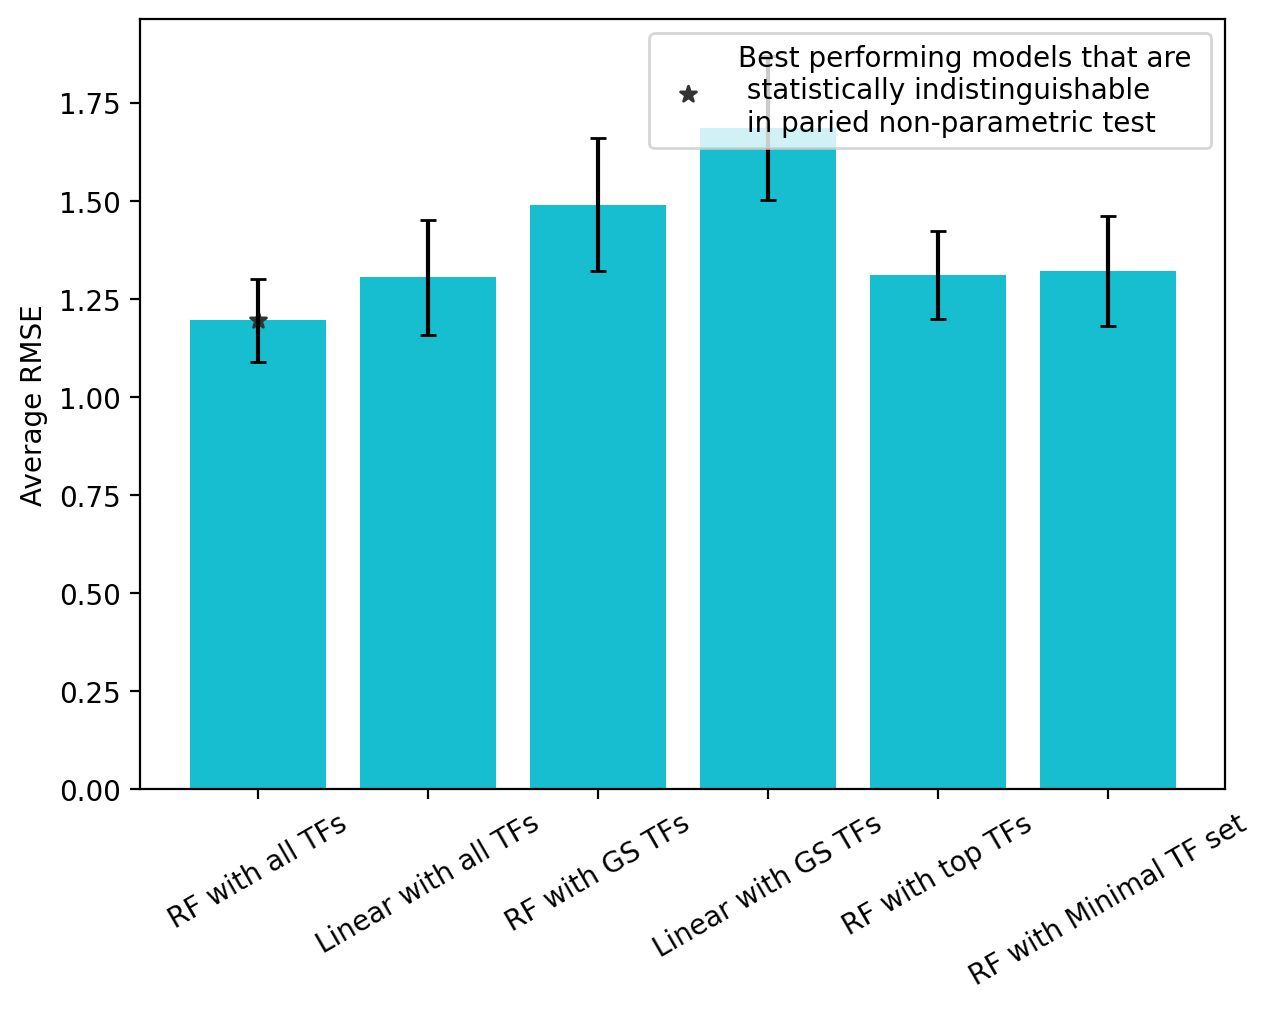

In [57]:
# plt.style.use("seaborn-v0_8")
df = res_df_list[3]
best_models = [0]
best_model_names = [compare_name_list[i] for i in best_models]
best_model_rmse = [df[compare_list[i]].mean() for i in best_models]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(6):
    ax.bar(compare_name_list[i], df[compare_list[i]].mean(), color=colors[9], yerr=df[compare_list[i]].sem(), capsize=3)
ax.scatter(best_model_names,best_model_rmse, marker='*', label='Best performing models that are \n statistically indistinguishable \n in paried non-parametric test', color="#333")
# ax.set_xticklabels(compare_name_list)
ax.set(ylabel='Average RMSE')
plt.xticks(rotation=30)
plt.legend()
plt.savefig('./plot_output/rmse_bar/mouse.pdf', bbox_inches='tight')

In [12]:
df[compare_list[i]].sem()

0.1400532350459316

In [149]:
stats.ttest_rel(df['rf_rmse'], df['rf_efron_rmse'])

TtestResult(statistic=-2.5633310791875994, pvalue=0.010840446514906035, df=309)

In [151]:
df[compare_list].mean()

rf_rmse                            1.195169
linear_rmse                        1.305100
gs_rf_rmse                         1.490031
gs_linear_rmse                     1.686018
rf_top_tf_same_count_as_gs_rmse    1.310031
rf_efron_rmse                      1.213142
dtype: float64